In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [21]:
def get_df(model, ra, metric, seed):
    df = pd.read_csv(f"results/{model}/{metric}/ra{ra}-{seed}.csv")
    df["model"] = model
    df["ra"] = ra
    df["metric"] = metric
    df["seed"] = seed
    return df


models = ["2d-lran", "2d-fno2d", "2d-fno3d"]
ras = [10000, 30000, 100000, 300000, 1000000, 3000000, 10000000]
seeds = [0, 1, 2, 3, 4]
metrics = ["RMSE", "R-MSE"]

# collect all data into one big DataFrame
df = pd.concat(
    [get_df(m, r, "R-MSE", seed) for m in models for r in ras for seed in seeds],
    ignore_index=True,
)

# Prediction Error vs Ra

In [22]:
# 1) collapse each run (model, ra, seed) to a single scalar: mean error over all samples & timesteps
per_run = (
    df.groupby(["model", "ra", "seed"], as_index=False)["value"]
    .mean()
    .rename(columns={"value": "run_mean"})
)

# 2) aggregate across seeds (between-run variability)
summary = (
    per_run.groupby(["model", "ra"])["run_mean"]
    .agg(mu="mean", sigma="std", n_runs="count", best="min", median="median")
    .reset_index()
)

# standard error and 95% CI for convenience
summary["se"] = summary["sigma"] / np.sqrt(summary["n_runs"]).replace(0, np.nan)
summary["ci95"] = 1.96 * summary["se"]

# nice sort by Ra (numeric) and model
summary = summary.sort_values(["model", "ra"]).reset_index(drop=True)

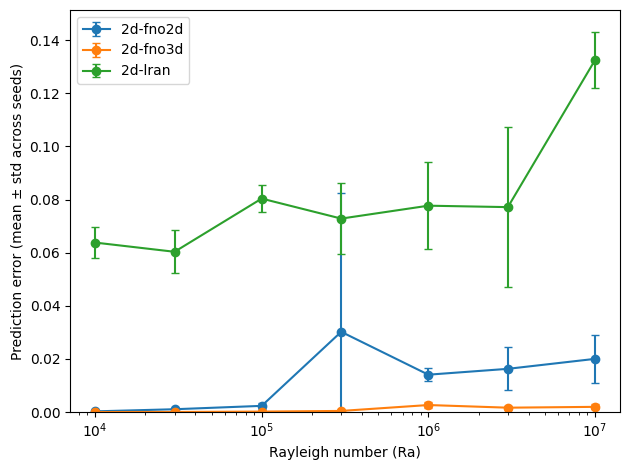

In [26]:
for model, sub in summary.groupby("model"):
    x = sub["ra"].values
    y = sub["mu"].values
    yerr = sub["sigma"].values
    plt.errorbar(x, y, yerr=yerr, marker="o", capsize=3, label=model)

plt.xlabel("Rayleigh number (Ra)")
plt.ylabel("Prediction error (mean ± std across seeds)")
plt.xscale("log")
plt.ylim(bottom=0)
plt.legend()
plt.tight_layout()

# Prediction Error vs Time in Sequence

In [28]:
def prepare_error_vs_time_bands(df: pd.DataFrame, ra, metric=None):
    """
    df columns: ['idx','batch_idx','sample_idx','step','value','model','ra','metric','seed']
    Returns per-model curves with:
      - mu: mean across seeds of per-run means
      - sigma_seed: std across seeds of per-run means (between-seed variability)
      - sigma_within_mean: mean across seeds of per-run stds (within-run variability)
      - sigma_within_pooled: pooled within-run std across seeds (accounts for n per run)
      - n_runs: number of seeds available per step
    """
    d = df.copy()
    d = d[d["ra"] == ra]
    if metric is not None and "metric" in d.columns:
        d = d[d["metric"] == metric]

    # 1) Per-run, per-time mean and std over samples (within-run stats)
    # count is helpful for pooled std later
    per_run_time = (
        d.groupby(["model", "seed", "step"])["value"]
        .agg(run_mean_t="mean", run_std_t="std", n_in_run="count")
        .reset_index()
    )

    # 2) Aggregate across seeds at each time
    def pooled_std(group):
        # pooled within-run variance across seeds (per model, per step)
        # sum_i ( (n_i - 1)*s_i^2 ) / (sum_i n_i - k )
        n = group["n_in_run"].values.astype(float)
        s = group["run_std_t"].values.astype(float)
        k = len(group)
        dof = n.sum() - k
        if dof <= 0:
            return np.nan
        num = ((n - 1) * (s**2)).sum()
        return np.sqrt(num / dof)

    across = (
        per_run_time.groupby(["model", "step"])
        .apply(
            lambda g: pd.Series(
                {
                    "mu": g["run_mean_t"].mean(),
                    "sigma_seed": g["run_mean_t"].std(ddof=1),
                    "sigma_within_mean": g["run_std_t"].mean(),
                    "sigma_within_pooled": pooled_std(g),
                    "n_runs": len(g),
                }
            )
        )
        .reset_index()
        .sort_values(["model", "step"])
        .reset_index(drop=True)
    )

    # standard error / CI for the between-seed mean if you need it
    across["se_seed"] = across["sigma_seed"] / np.sqrt(across["n_runs"]).replace(
        0, np.nan
    )
    across["ci95_seed"] = 1.96 * across["se_seed"]

    return across, per_run_time

In [29]:
def plot_time_with_bands(
    curve: pd.DataFrame,
    within="mean",  # "mean" or "pooled"
    show_seed_band=True,
    title=None,
):
    """
    within: choose within-run band source:
        - "mean"   -> uses sigma_within_mean
        - "pooled" -> uses sigma_within_pooled
    show_seed_band: if True, draws an outer band for between-seed std
    """
    within_col = "sigma_within_mean" if within == "mean" else "sigma_within_pooled"

    for model, sub in curve.groupby("model"):
        x = sub["step"].values
        mu = sub["mu"].values
        sig_within = sub[within_col].values
        plt.plot(x, mu, label=model)

        # Inner band = within-run variability (aggregated across seeds)
        plt.fill_between(
            x, mu - sig_within, mu + sig_within, alpha=0.25, label=f"{model} (within)"
        )

        # Outer band = between-seed variability (optional)
        if show_seed_band:
            sig_seed = sub["sigma_seed"].values
            plt.fill_between(
                x, mu - sig_seed, mu + sig_seed, alpha=0.15, label=f"{model} (seed)"
            )

    plt.xlabel("Time step")
    plt.ylabel("Prediction error")
    if title:
        plt.title(title)
    # Avoid duplicate legend entries by handling labels carefully, or call:
    handles, labels = plt.gca().get_legend_handles_labels()
    # Deduplicate labels
    uniq = dict(zip(labels, handles))
    plt.legend(uniq.values(), uniq.keys(), frameon=False)
    plt.tight_layout()

/var/folders/0d/br1vdfzs2gvdmcsrbnbdn8mr0000gn/T/ipykernel_38418/3804860933.py:40: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


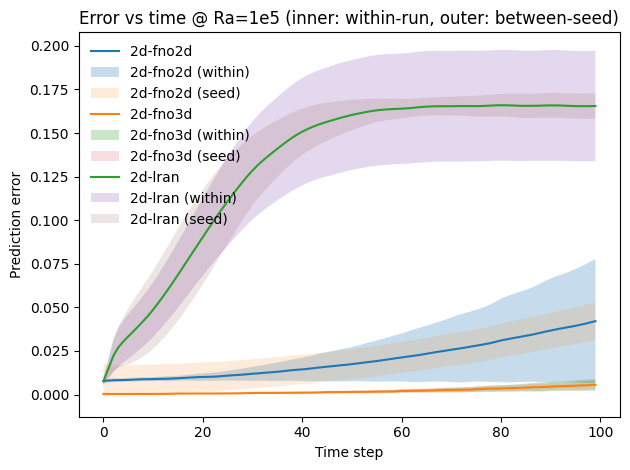

In [37]:
curve, per_run_time = prepare_error_vs_time_bands(df, ra=10_000_000, metric="R-MSE")

# Inner = within-run (mean of per-run stds), outer = between-seed std
plot_time_with_bands(
    curve,
    within="mean",
    show_seed_band=True,
    title="Error vs time @ Ra=1e5 (inner: within-run, outer: between-seed)",
)
plt.show()

## Old Code

In [24]:
# --- Option A: plot with mean + std shading ---
# plt.figure(figsize=(8, 5))
# sns.lineplot(
#     data=df_all,
#     x="ra",
#     y="value",  # prediction error column
#     hue="model",
#     marker="o",
#     estimator="mean",  # mean error across samples/steps
#     errorbar="sd",  # shaded std deviation
# )
# plt.xscale("log")
# plt.xlabel("Rayleigh number (Ra)")
# plt.ylabel("Prediction error")
# plt.ylim(0, 1)
# plt.title("Prediction error vs. Rayleigh number")
# plt.grid(True, which="both", ls="--", lw=0.5)
# plt.tight_layout()
# plt.show()

# Prediction Error vs Time in Sequence

In [25]:
def plot_error_over_time(df_all: pd.DataFrame, ra_sel: int | float):
    df_ra = df_all[df_all["ra"] == ra_sel].copy()
    # (Optional) ensure steps are sorted
    df_ra = df_ra.sort_values("step")

    plt.figure(figsize=(8, 5))
    sns.lineplot(
        data=df_ra,
        x="step",
        y="value",
        hue="model",
        estimator="mean",  # mean across idx/batch/sample
        errorbar="sd",  # shaded std per step (use ("ci",95) for CI)
    )
    plt.xlabel("Prediction step")
    plt.ylabel("Prediction error")
    plt.ylim(0, 0.5)
    plt.title(f"Prediction error over time @ Ra = {ra_sel}")
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
    plt.tight_layout()
    plt.show()


# Example:
# for ra in ras:
#     plot_error_over_time(df_all, ra_sel=ra)